# Neural and Evolutionary Learning - Final Project

## Notebook 2 - Problem Applications

## **2.3.** *Neuroevolution* - `NEvol`

|       Student Name      |    Student ID   |
|           ---           |       ---       |
|     Andriani Kakoulli   |     20230484    |
|       Susana Pires      |     20230540    |

### **1. Introduction**

> **CONTEXT** <br>

Data from Automatic Milking Systems (AMSs). <br>

Milk contents (fat, protein, lactose) are emasured at each milking event, to evaluate milk quality. This measurement is through a colourimetric mehtod that requires calibration every 2 weeks. <br>

> **GOAL** <br>

To infer the milk components - *Lactose* - from the other sensor data from the milking robots. <br>
Develop model to **predict** Lactose content.

> **GPOL**-based implementations

> **1.** **Search Space** definition <br>
> Python dictionary with following elements: <br>
> - *n_dims*  <br>
> - *function_set*  <br>
> - *constant_set*  <br>
> - *p_constants*  <br>
> - *max_init_depth*  <br>
> - *max_depth*  <br>
> - *n_batches*  <br>
> - *device*  <br>
> <br>
> 
> **2.** **Problem Instance** definition  <br>
> Instantiantion of a SML (supervised-ML) object, it requires:  <br>
> - *fitness function*  <br>
> - *train data loader*  <br>
> - *number of jobs for parallel processing* <br>
> Optional: can take test data loader object.  <br>
> <br>
>
> **3.** **Algorithm** definition  <br>
> Instantiation of a Genetic Algorithm object, requires definitions of:  <br>
> - *problem instance*  <br>
> - *initialization methods*  <br>
> - *crossover operators*  <br>
> - *mutation operators*  <br>
> - *crossover probabilities*  <br>
> - *mutation probabilities*  <br>
> - *elitism*  <br>
> - *reproduction*  <br>
> - *device on evaluations will be processed*  <br>
> - *random seed*  <br>

### **2. Environment preparation**

### -> `2.8: same procedure in one cell`
*The folowwing code 2.1-2.7 is step by step procedure with printing and checking each step. In 2.8, we follow the same procedure BUT in one cell with cross validation among the four optimizers.

#### **2.1. Imports**

In [1]:
#pip install mlxtend

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop

from gpolnel.utils.utils import train_test_split
from gpolnel.utils.utils import load_cleaned_data
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from tqdm import tqdm
%matplotlib inline

#### **2.2. Global settings**

In [3]:
tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


#### **2.3. Data load**

To use the data loader<br>
- folder *problems* - file *problem* <br>
- folder *utils* - file *solution* <br>
- the data loader is instantiated inside SML (folder *problems* in file *inductive_programming*) <br>

In [4]:
X, y = load_cleaned_data(X_y=True)

In [5]:
print(X.shape, y.shape)

torch.Size([177, 14]) torch.Size([177])


#### **2.4. Data split**

In [6]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.3, seed=27)

# Train and validation sets, load from X_train and y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, p_test=0.3, seed=27)
total_batches = 1 
batch_size = X_train.shape[0]
print(f'Batch size: {batch_size}\nTotal batches: {total_batches}\n')

print(f'Train:\t{X_train.shape[0]}\nVal:\t{X_val.shape[0]}\nTest:\t{X_test.shape[0]}')
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

Batch size: 87
Total batches: 1

Train:	87
Val:	37
Test:	53
Total:	177


In [7]:
# MinMax scaler scikitlearn
mm_scaler = MinMaxScaler()
scaled_min_max_train = mm_scaler.fit_transform(X_train)
scaled_min_max_val = mm_scaler.transform(X_val)
scaled_min_max_test = mm_scaler.transform(X_test)

#### **2.5.**
**Neural Network instance & architecture (Steps 1 and 2) |** <br>
**Define loss funtion and optimizers (Step 3 and 4) |** <br>
**Compile model (step 5)**

In [8]:
with tf.device('/cpu:0'):
    m = Sequential()
    m.add(keras.Input(shape=(X_train.shape[1], )))
    # Explicity initialize weights and bias
    m.add(Dense(2, 
                activation='relu',
                kernel_initializer=tf.keras.initializers.GlorotUniform(),
                bias_initializer=tf.keras.initializers.Zeros()))
    m.add(Dense(1))  # No activation function for regression

    
    nn_tf = {}
    for k in ['GD', 'SGD', 'MiniSGD', 'RMSprop']:
        nn_tf.update({k: tf.keras.models.clone_model(m)})
    learning_rate = 0.01
    nn_tf['GD'].compile(optimizer=SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    nn_tf['SGD'].compile(optimizer=SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    nn_tf['MiniSGD'].compile(optimizer=SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    nn_tf['RMSprop'].compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mse', metrics=['mae'])

##### **2.6. NN fit**

In [9]:
num_epochs = 500
batch_size_GD = 150
batch_size_SGD = 1
batch_size_MiniSGD = 32

# Cheking batch sizes
[batch_size_GD, batch_size_SGD, batch_size_MiniSGD]

[150, 1, 32]

In [10]:
history_tf = {}
num_epochs = 500

print('Training GD model... ', end='')
history_tf['GD'] = nn_tf['GD'].fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size_GD, verbose=0)
print('Finished.')

print('Training SGD model... ', end='')
history_tf['SGD'] = nn_tf['SGD'].fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size_SGD, verbose=0)
print('Finished.')

print('Training MiniSGD model... ', end='')
history_tf['MiniSGD'] = nn_tf['MiniSGD'].fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size_MiniSGD, verbose=0)
print('Finished.')

print('Training RMSprop model... ', end='')
history_tf['RMSprop'] = nn_tf['RMSprop'].fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size_MiniSGD, verbose=0)
print('Finished.')

Training GD model... Finished.
Training SGD model... Finished.
Training MiniSGD model... Finished.
Training RMSprop model... Finished.


#### **2.7. Evaluate the models**

In [11]:
for k, model in nn_tf.items():
    loss, mae = model.evaluate(X_val, y_val, verbose=0)
    print(f"{k} model - Loss: {loss}, MAE: {mae}")

GD model - Loss: 0.004261180758476257, MAE: 0.047774650156497955
SGD model - Loss: 0.004228954669088125, MAE: 0.04775114357471466
MiniSGD model - Loss: 0.004258383065462112, MAE: 0.04777265340089798
RMSprop model - Loss: 0.004105675965547562, MAE: 0.04764822497963905


> (all above code in one cell)

### **2.8** Training the model & Evaluate four optimizers with 5-fold cross validation 


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop

from gpolnel.utils.utils import load_cleaned_data

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np


tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Generate  regression data
X, y = load_cleaned_data(X_y=True)

# Parameters
learning_rate = 0.01
num_epochs = 500
k_folds = 5

# Define the KFold cross-validator | random split
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store the results of each fold
results = {k: [] for k in ['GD', 'SGD', 'MiniSGD', 'RMSprop']}
histories = {k: [] for k in ['GD', 'SGD', 'MiniSGD', 'RMSprop']}

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}/{k_folds}...")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # NN instance & architecture
    with tf.device('/cpu:0'):
        m = Sequential()
        m.add(keras.Input(shape=(X_train.shape[1], )))
        m.add(Dense(2, 
                    activation='relu',
                    kernel_initializer=tf.keras.initializers.GlorotUniform(),
                    bias_initializer=tf.keras.initializers.Zeros()))
        m.add(Dense(1))  # No activation function for regression

        # Compile models NNs
        nn_tf = {}
        for k in ['GD', 'SGD', 'MiniSGD', 'RMSprop']:
            nn_tf[k] = tf.keras.models.clone_model(m)
        nn_tf['GD'].compile(optimizer=SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])
        nn_tf['SGD'].compile(optimizer=SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])
        nn_tf['MiniSGD'].compile(optimizer=SGD(learning_rate=learning_rate), loss='mse', metrics=['mae'])
        nn_tf['RMSprop'].compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mse', metrics=['mae'])


    batch_size_GD = X_train.shape[0]
    batch_size_SGD = 1
    batch_size_MiniSGD = 32
    batch_size_RMSprop =32

    # Train models
    for k in nn_tf.keys():
        print(f'Training {k} model...')
        history = nn_tf[k].fit(
            x=X_train, y=y_train, validation_data=(X_val, y_val), 
            epochs=num_epochs, batch_size=eval(f'batch_size_{k}'), verbose=0
        )
        histories[k].append(history)

        # Evaluate the model
        loss, mae = nn_tf[k].evaluate(X_val, y_val, verbose=0)
        results[k].append(mae)
        print(f"{k} model - Fold {fold + 1} - Loss: {loss}, MAE: {mae}")

# Calculate and print average MAE for each model
for k in results.keys():
    avg_mae = np.mean(results[k])
    print(f"{k} model - Average MAE: {avg_mae}")


Num GPUs Available:  0
Training fold 1/5...
Training GD model...
GD model - Fold 1 - Loss: 0.0038318289443850517, MAE: 0.04833867773413658
Training SGD model...
SGD model - Fold 1 - Loss: 0.003781544975936413, MAE: 0.047974321991205215
Training MiniSGD model...
MiniSGD model - Fold 1 - Loss: 0.0038379919715225697, MAE: 0.04838252067565918
Training RMSprop model...
RMSprop model - Fold 1 - Loss: 1.1178972721099854, MAE: 0.2840084731578827
Training fold 2/5...
Training GD model...
GD model - Fold 2 - Loss: 0.0022825878113508224, MAE: 0.042462244629859924
Training SGD model...
SGD model - Fold 2 - Loss: 0.002327520865947008, MAE: 0.04316708818078041
Training MiniSGD model...
MiniSGD model - Fold 2 - Loss: 0.0022831670939922333, MAE: 0.042469341307878494
Training RMSprop model...
RMSprop model - Fold 2 - Loss: 0.3221275806427002, MAE: 0.5499308109283447
Training fold 3/5...
Training GD model...
GD model - Fold 3 - Loss: 0.006025249138474464, MAE: 0.06447087973356247
Training SGD model...
S

ANOVA test is significant, indicating differences among the models.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
     GD MiniSGD      0.0    1.0 -0.1994  0.1994  False
     GD RMSprop   0.2152 0.0321  0.0159  0.4146   True
     GD     SGD   0.0003    1.0 -0.1991  0.1997  False
MiniSGD RMSprop   0.2152 0.0321  0.0158  0.4146   True
MiniSGD     SGD   0.0003    1.0 -0.1991  0.1997  False
RMSprop     SGD  -0.2149 0.0324 -0.4143 -0.0155   True
------------------------------------------------------


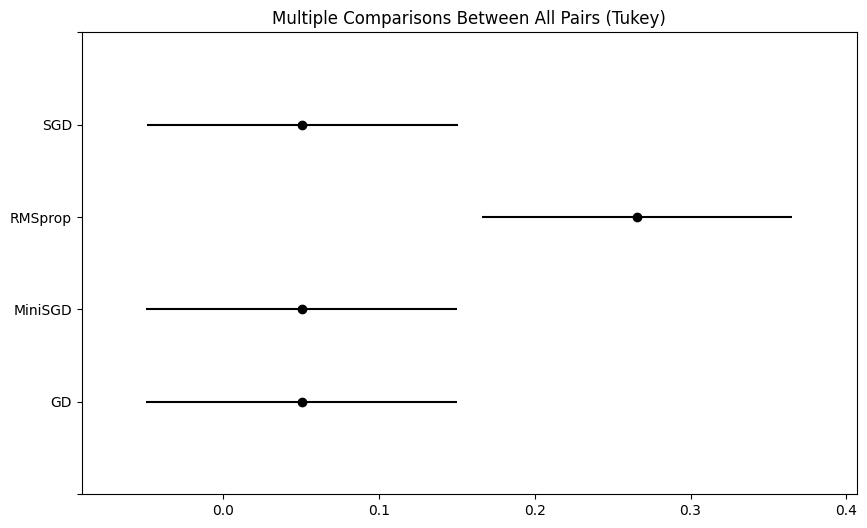

In [5]:
from scipy.stats import ttest_rel, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform ANOVA test
f_statistic, p_value = f_oneway(results['GD'], results['SGD'], results['MiniSGD'], results['RMSprop'])

# Check if the ANOVA test is significant
if p_value < 0.05:
    print("ANOVA test is significant, indicating differences among the models.")

    # Perform post-hoc analysis (Tukey's HSD test)
    model_names = ['GD', 'SGD', 'MiniSGD', 'RMSprop']
    all_results = np.concatenate([results[model] for model in model_names])
    model_labels = np.concatenate([[model]*len(results[model]) for model in model_names])

    tukey_results = pairwise_tukeyhsd(all_results, model_labels)
    print(tukey_results)

    # Plotting the results
    tukey_results.plot_simultaneous()
    plt.show()
else:
    print("ANOVA test is not significant, indicating no differences among the models.")

Based on the output, the conclusion is to build the algorithm using one of the 3 optimizers: GD, SGD, MiniSGD, as they don't have significant difference based on both ANOVA test and MAE comparison. Though, the null hypothesis for statistically significant difference between pairs of optimizers and RMSProp is rejected, meaning that there is significant difference between RMSProp and the rest of the optimizers.

 We choose **Stochastic Gradient Descent**.

#### **2.9 Modeling only with GD-optimizer**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data ##
# Load data
X, y = load_cleaned_data(X_y=True)

# TRAIN - TEST(unseen)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
#### Modeling ##
# Model parameters
learning_rate = 0.01
num_epochs = 500
batch_size = 32

# TRAIN - VALIDATION (without touching the test data)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(2, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(X_train.shape[1],)),
    Dense(1)
])

# Compile the model with Gradient Descent optimizer
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model with train-validation data
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

## Evaluation of the model on test(unseen) data ##
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

# Print the evaluation results
print("Gradient Descent (GD) Model:")
print(f"Test Loss: {loss}, Test MAE: {mae}, Test RMSE: {rmse}")

c:\Users\andri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Gradient Descent (GD) Model:
Test Loss: 0.0031911106780171394, Test MAE: 0.0442485474050045, Test RMSE: 0.05763113498687744


##### Run 10 times => get each RMSE in a 10-dimensional vector

In [20]:
import statistics

# list of 10 RMSE-test values
list_RMSE = [0.05796981230378151, 0.05761600658297539, 0.0578799806535244, 0.058431219309568405, 0.058440353721380234,
             0.05767446011304855, 0.05819113180041313, 0.057966023683547974, 0.05770725756883621, 0.05763113498687744]

# compute the median of list_RMSE
median_RMSE = statistics.median(list_RMSE)
round(median_RMSE, 6)

0.057923

> ##### **median RMSE on test set:** 0.057923
> ##### **RMSE vector to be used for evaluation:**
> RMSE_NN = [0.05796981230378151, 0.05761600658297539, 0.0578799806535244, 0.058431219309568405, 0.058440353721380234, 0.05767446011304855, 0.05819113180041313, 0.057966023683547974, 0.05770725756883621, 0.05763113498687744]


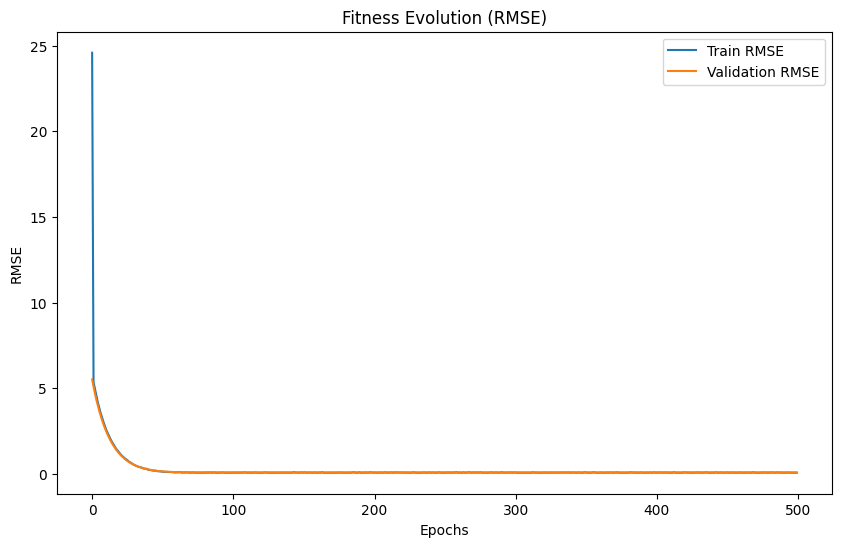

In [21]:
# Extract RMSE values from the training history
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

# Plot the fitness evolution (RMSE) with GD
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Fitness Evolution (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
#plt.ylim(bottom=-2e5, top=8e5)  # to zoom in
plt.legend()
plt.show()

*Since we are not using a genetic algorithm or similar evolutionary strategy, there is no concept of "solution size", and thus plotting its evolution wouldn't be applicable in this case.